In [1]:
from sklearn.cluster import KMeans
import numpy
import plotly.express as px
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import umap

RANDOM_SEED = 33

/home/julio/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explorando clusters a partir dos scores NLI dos tweets

In [2]:
PATH_PETR4_TRAIN_TWEETS_SCORES = 'Text/data/PETR4_preprocessed_tweets_scores_train.csv'
PATH_VALE3_TRAIN_TWEETS_SCORES = 'Text/data/VALE3_preprocessed_tweets_scores_train.csv'

df_petr4_train_tweets_scores = pd.read_csv(PATH_PETR4_TRAIN_TWEETS_SCORES)
df_vale3_train_tweets_scores = pd.read_csv(PATH_VALE3_TRAIN_TWEETS_SCORES)

Escolhendo features relevantes para análise

In [3]:
numeric_features2keep = ['retweetCount',
 'likeCount',
 'author_isVerified',
 'author_followers',
 'author_following',
 'author_favouritesCount',
 'valorização',
 'bom negócio',
 'lucro',
 'neutro',
 'desvalorização',
 'mau negócio',
 'prejuízo',
 'governo']

In [4]:
from sklearn.preprocessing import StandardScaler

std_scal_petr4 = StandardScaler()
std_scal_petr4.fit(df_petr4_train_tweets_scores[numeric_features2keep])
petr4_train_normalized_cols = std_scal_petr4.transform(df_petr4_train_tweets_scores[numeric_features2keep])
df_petr4_train_tweets_scores_norm = pd.DataFrame(petr4_train_normalized_cols, columns=[f'norm_{col}' for col in numeric_features2keep])

std_scal_vale3 = StandardScaler()
std_scal_vale3.fit(df_vale3_train_tweets_scores[numeric_features2keep])
vale3_train_normalized_cols = std_scal_vale3.transform(df_vale3_train_tweets_scores[numeric_features2keep])
df_vale3_train_tweets_scores_norm = pd.DataFrame(vale3_train_normalized_cols, columns=[f'norm_{col}' for col in numeric_features2keep])

# Clustering

## VALE3

In [5]:
k_list = list(range(2, 20))
silhouette_score_list = []
for k in k_list:
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    model_kmeans = model_kmeans.fit(df_vale3_train_tweets_scores_norm)
    s_score = silhouette_score(df_vale3_train_tweets_scores_norm, model_kmeans.predict(df_vale3_train_tweets_scores_norm))
    silhouette_score_list.append(s_score)

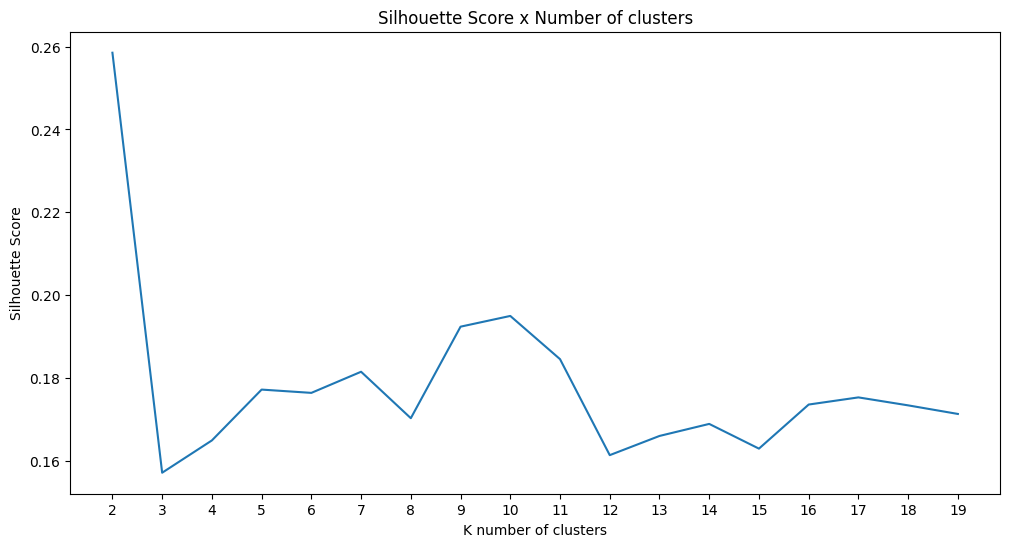

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

In [7]:
k_clusters = 2
model_kmeans = KMeans(n_clusters=k_clusters, random_state=RANDOM_SEED, n_init=10)
model_kmeans = model_kmeans.fit(df_vale3_train_tweets_scores_norm)

In [8]:
vale3_wraped_tweets_train = df_vale3_train_tweets_scores['text'].str.wrap(90).apply(lambda x: x.replace('\n', '<br>'))

In [9]:
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=RANDOM_SEED)
X_umap = umap_reducer.fit_transform(df_vale3_train_tweets_scores_norm)

X_clusters = model_kmeans.predict(df_vale3_train_tweets_scores_norm)

df_pca = pd.DataFrame(X_umap, columns=['pca_dim1', 'pca_dim2'])
df_pca['cluster'] = X_clusters.astype(str)
df_pca['text'] = vale3_wraped_tweets_train

px.scatter(df_pca, x='pca_dim1', y='pca_dim2', color='cluster', hover_name='text', title='PCA Clustering Plot')

/home/julio/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [10]:
df_vale3_aux = df_vale3_train_tweets_scores[numeric_features2keep].copy()
df_vale3_aux['cluster'] = X_clusters
df_vale3_aux['text'] = df_vale3_train_tweets_scores['text']

In [11]:
relevant_features = ['bom negócio', 'desvalorização', 'mau negócio', 'prejuízo', 'governo']
df_vale3_aux.groupby('cluster')[relevant_features].mean()

,bom negócio,desvalorização,mau negócio,prejuízo,governo
cluster,,,,,
0,0.268894,0.904529,0.571061,0.812738,0.470438
1,0.666642,0.226139,0.024003,0.130041,0.278341


Note que o cluster 0 em geral nos fornece a ideia de tweets que indicam que NÃO é uma boa ideia comprar a ação, e que a mesma está em queda! Ao contrário do cluster 1

Vamos exibir alguns tweets aleatórios de cada cluster:

In [12]:
from IPython.display import display

In [15]:
df_vale3_aux_cluster0 = df_vale3_aux[['cluster', 'text']].query('cluster == 0').reset_index(drop=True)
df_aux = df_vale3_aux_cluster0.sample(n=10, random_state=RANDOM_SEED)


display(df_aux.style.set_properties(**{
    'text-align':'center',
    'white-space':'pre-wrap'    
}))

,cluster,text
213,0,"VALE3 a R$ 100 é um pulo. Como falei, 0,5% por dia."
42,0,"Vale ON #VALE3 cai 2,3% e contribui para queda de 0,1% do #IBOV, aos 98.161 pontos, mesmo com alta em NY. Vale recua ocorre após dados operacionais do 2T22 e redução do guidance de produção de minério de ferro. Relatório: https://t.co/NUCSGeiFRH"
452,0,"CMIN3 sobe; VALE3 cai. Em termos de fundamento, não consigo explicar."
200,0,"Minério de ferro: desvalorização afunda ações da Vale (VALE3), CSN (CSNA3) e CSN Mineração (CMIN3) - https://t.co/BVThaqWfsT"
198,0,Minério de ferro cai com cenário de demanda afetado por problemas de Covid na China - https://t.co/xIrtDrz5v9 #VALE3 #CMIN3
165,0,Minério de ferro amplia perdas com aumento de casos de Covid na China - https://t.co/X717yVTQYc #VALE3 #CMIN3
454,0,"📉 As ações da Vale (#VALE3) estavam em baixa às 16h11 da sessão desta quarta-feira (20). Os ativos recuavam 2,18%, cotados a R$ 67,80. #mercadofinanceiro #Investimentos https://t.co/xMKqCIaQxT https://t.co/ryWwpwjiuF"
323,0,"++Apesar de recente queda, Credit Suisse mantém visão de minério a US$ 120 e projeta recuperação de ações da Vale (#VALE3) (Infomoney)"
229,0,Desembargador pede vista e interrompe julgamento da Vale (VALE3) https://t.co/gHz0pI1fI5
27,0,As coisas não estão fáceis pro nosso índice! Minério pesando… #VALE3 https://t.co/HDAzcn1K0K


De fato, esse cluster em geral indica uma má fase da ação da VALE3!

In [16]:
df_vale3_aux_cluster1 = df_vale3_aux[['cluster', 'text']].query('cluster == 1').reset_index(drop=True)
df_aux = df_vale3_aux_cluster1.sample(n=10, random_state=RANDOM_SEED)


display(df_aux.style.set_properties(**{
    'text-align':'center',
    'white-space':'pre-wrap'    
}))

,cluster,text
32,1,$Vale pretende investir US$400 mi na eliminação de barragens em 2022 - https://t.co/KdL3Ib9J72 #VALE3
945,1,Vale (#VALE3): O acordo que pode tornar a mineradora ainda mais atrativa. https://t.co/xrqHUuJhni
741,1,"VALE3 Você leva uma empresa que gera um baita caixa. Leva uma empresa que entrega retorno bem acima do custo de capital. Leva uma empresa que não tem “preocupação” com estrutura de capital. Leva qualidade, um ativo único no mundo. É aquela empresa: “quero ser sócio”"
1214,1,Vamos lá! O que esses papéis tem em comum no gráfico mensal? 🤔 #west3 #haga4 #raiz4 #lwsa3 #mrfg3 #bbdc4 #tasa4 #jbss3 #irbr3 #vale3 https://t.co/2zNIz5CHuD
443,1,"Os contratos do minério com vencimento para Fevereiro de 2023 negociados na Bolsa de Dalian, fecharam em alta de +1,32% cotados a 808,50 Iuanes o equivalente a U$116,41 em dólares por tonelada #IRONORE #VALE3 https://t.co/7PDAOWnOZY"
440,1,🗓️ Agenda de Dividendos 💰confira as ações que pagarão proventos nos próximos dias. Os valores levam em conta Dividendos e Juros Sobre o Capital Próprio (JCP): #BBAS3 #VALE3 #DXCO3 #AURA33 #DIRR3 #MDIA3 #SUZB3 #ABEV3 #VIVT3 https://t.co/pHkIcLv8F9
371,1,"Uma união que veio para ficar: Cade libera aumento da fatia da Cosan (CSAN3) dentro da Vale (VALE3) para 6,5%. #SeuDinheiro https://t.co/EUIEF5alTi https://t.co/FEnKBafZhi"
366,1,Vale (VALE3) e grandes empresas se unem para restaurar 4 milhões de hectares de florestas https://t.co/nheE9aBcya
1165,1,Que máquina de gerar valor ao acionista essa #VALE3 😳 https://t.co/hN2d3q2Rjc
1190,1,"📈 As três ações que mais valorizaram no dia foram: Usiminas (#USIM5), Vale (#VALE3) e Bradespar (#BRAP4) https://t.co/IF8jwnwjHk"


E em geral, o cluster 1 indica uma boa fase da ação VALE3!

## PETR4

In [17]:
k_list = list(range(2, 20))
silhouette_score_list = []
for k in k_list:
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    model_kmeans = model_kmeans.fit(df_petr4_train_tweets_scores_norm)
    s_score = silhouette_score(df_petr4_train_tweets_scores_norm, model_kmeans.predict(df_petr4_train_tweets_scores_norm))
    silhouette_score_list.append(s_score)

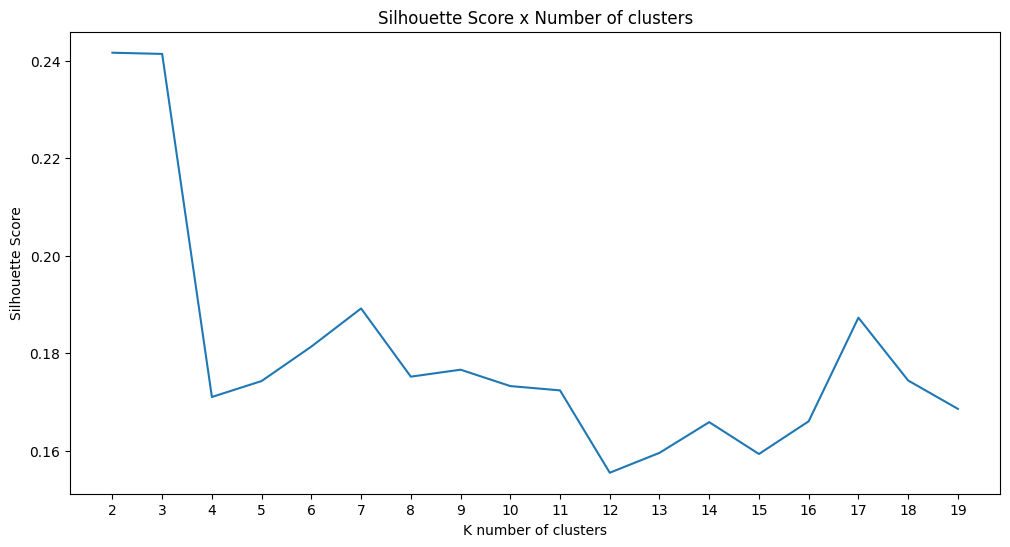

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

In [19]:
k_clusters = 2
model_kmeans = KMeans(n_clusters=k_clusters, random_state=RANDOM_SEED, n_init=10)
model_kmeans = model_kmeans.fit(df_petr4_train_tweets_scores_norm)

In [20]:
petr4_wraped_tweets_train = df_petr4_train_tweets_scores['text'].str.wrap(90).apply(lambda x: x.replace('\n', '<br>'))

In [21]:
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=RANDOM_SEED)
X_umap = umap_reducer.fit_transform(df_petr4_train_tweets_scores_norm)

X_clusters = model_kmeans.predict(df_petr4_train_tweets_scores_norm)

df_pca = pd.DataFrame(X_umap, columns=['pca_dim1', 'pca_dim2'])
df_pca['cluster'] = X_clusters.astype(str)
df_pca['text'] = petr4_wraped_tweets_train

px.scatter(df_pca, x='pca_dim1', y='pca_dim2', color='cluster', hover_name='text', title='PCA Clustering Plot')

/home/julio/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [22]:
df_petr4_aux = df_petr4_train_tweets_scores[numeric_features2keep].copy()
df_petr4_aux['cluster'] = X_clusters
df_petr4_aux['text'] = df_petr4_train_tweets_scores['text']

In [23]:
relevant_features = ['bom negócio', 'desvalorização', 'mau negócio', 'prejuízo', 'governo']
df_petr4_aux.groupby('cluster')[relevant_features].mean()

,bom negócio,desvalorização,mau negócio,prejuízo,governo
cluster,,,,,
0,0.624503,0.304058,0.033837,0.166606,0.339767
1,0.172460,0.816610,0.604666,0.792424,0.506957


Note que o cluster 0 em geral nos fornece a ideia de tweets que indicam uma impressão **POSITIVA** sobre a ação! Ao contrário do cluster 1

Vamos exibir alguns tweets aleatórios de cada cluster:

In [24]:
df_petr4_aux_cluster0 = df_petr4_aux[['cluster', 'text']].query('cluster == 0').reset_index(drop=True)
df_aux = df_petr4_aux_cluster0.sample(n=10, random_state=RANDOM_SEED)


display(df_aux.style.set_properties(**{
    'text-align':'center',
    'white-space':'pre-wrap'    
}))

,cluster,text
121,0,#Petrobras descobre acumulação de gás natural em poço exploratório na Colômbia - https://t.co/ZcKtYMipJL #PETR4
296,0,Petrobras (PETR4) lança teaser para venda de rede de 8 mil km de fibra óptica onshore #Empresas #FibraÓptica #Petrobras https://t.co/HCJeXlsDUA
936,0,"🚨URGENTE - Petrobras define nova política de dividendo e distribuirá 45% do fluxo de caixa livre aos acionistas. Na política praticada até hoje, ela vinha pagando 60%, e analistas de mercado em geral apostavam corte para 40% #PETR4 -via ⁦@Reuters⁩ ⁦@tcinvestimentos⁩ https://t.co/hgWsop3l67"
32,0,"Andrade tomará posse na terça-feira como presidente da Petrobras (PETR4), diz assessoria #Empresas #Petrobras #Reuters https://t.co/nSIL4p0J87"
968,0,"#PETR4 $PBR 🇧🇷 SANTANDER INVESTMENT REITERA ´COMPRA´ EM PETROBRAS APÓS POLÍTICA DIVIDENDO SANTANDER VÊ PETROBRAS COM ´DIVIDEND YIELD´ DE 13% EM 2023, 9% EM 2024 SANTANDER VÊ PETROBRAS NEGOCIADA A MÚLTIPLO EV/EBITDA 40% ABAIXO DE PARES SANTANDER: NOVA POLÍTICA DIVIDENDO PETROBRAS VEM EM LINHA COM EXPECTATIVAS"
750,0,Ibovespa: GOLL4 e ALPA4 disparam; PETR4 e VALE3 sustentam o índice; entenda #Ações #Alpargatas #Empresas https://t.co/nDVt8wiA2T
279,0,"#PETR4 - Petrobras prevê aumentar em mais de três vezes a capacidade instalada de produção no campo de Búzios, no pré-sal da bacia de Santos, até o final da década. A projeção é de que o volume salte dos atuais 600 mil barris diários de petróleo por dia. (Broadcast)"
439,0,"#PETR4 - Relatório elaborado pelo subgrupo de óleo e gás da transição propõe a criação de um plano de expansão do refino nacional no prazo de 60 dias. Documento traz quatro propostas para o setor com prazos de realização, parte delas implicando diretamente a Petrobras. (Estadão)"
1200,0,"A #petr4 entregou resultado oposto das jrs, que entregaram crescimento e expansão de margens. Queda de receita, margens e geração de caixa. A nova gestão já mostrou como será a empresa nos próximos períodos!"
755,0,Petrobras (PETR4) anuncia redução de quase 10% do preço do diesel a partir de sábado https://t.co/mGurjxiZR4


De fato, esse cluster em geral menciona tweets positivos sobre a PETR4!

In [25]:
df_petr4_aux_cluster1 = df_petr4_aux[['cluster', 'text']].query('cluster == 1').reset_index(drop=True)
df_aux = df_petr4_aux_cluster1.sample(n=10, random_state=RANDOM_SEED)


display(df_aux.style.set_properties(**{
    'text-align':'center',
    'white-space':'pre-wrap'    
}))

,cluster,text
157,1,"Vi alguns questionando: ""Por que as PUTs de PETR4 se desvalorizaram mesmo com as ações caindo 8,47% no dia?"" Imagino a frustração de quem acertou o lado e perdeu dinheiro. Por isto, segue o🧶 para que você não cometa erros daqui pra frente⬇️"
44,1,"Dividendos bilionários da Petrobras (PETR4), Magazine Luiza (MGLU3) despenca: veja as notícias mais lidas da semana - https://t.co/rihGNUljjl"
374,1,"Petrobras, que anunciou emissão de bonds, ajudou a reduzir as perdas: PETR4 +2,29% e PETR3 +1,95%. Lá fora, techs são as perdedoras do dia. https://t.co/XxbXFkb7u7"
276,1,"Bolsa hoje: Ibovespa despenca mais de 7% em fevereiro, enquanto dólar salta 2,9%; ameaça aos dividendos da Petrobras (PETR4) pressiona índice #SeuDinheiro #Bolsa #Ações https://t.co/J6IIj9gioM https://t.co/DSRsJXvfCb"
200,1,"Vale (VALE3), Petrobras (PETR4), B3 (B3SA3) e bancos sobem; siderúrgicas recuam – InfoMoney https://t.co/gKo8fk2IJU"
492,1,Órgão do Carf acolhe recurso do governo e torna definitivo débito de R$ 762 milhões da Petrobras (PETR4) https://t.co/igzl0dPUWF
297,1,"Não sou só eu que tô segurando a venda de Opções de PETR4 não ... Impressionante a fraqueza do relatório de posições em aberto delas. Nunca vi coisa parecida ! Seja em relação ao tamanho das posições vendidas, seja em relação ao número de participantes envolvidos ... 🤷🏻‍♂️"
415,1,#PETR4 a Petrobras tem a administração indicada por Lula a partir de maio. Com isso o primeiro balanço com 100% da nova administração será o 3t23. A geração de caixa será menor por conta do deságio de -20% no preço dos combustíveis. Deve cair mais nos trimestres sequentes
304,1,"#PETR4 *PETROBRAS SUSPENDERÁ 38 VENDAS DE ATIVOS, MANTENDO 6 OPERAÇÕES: TC MOVER"
66,1,#Ibovespa recua com #Petrobras entre maiores quedas; #BRF sobe - https://t.co/0Al0JDADnW #PETR4 #BRFS3


E em geral, o cluster 1 indica uma MÁ fase da ação PETR4!